In [47]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import math
from vyper.utils import SizeLimits

# plotting:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# for handling SettingWithCopyWarning
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Generate data using [the generation script](./generate_data.py) and store it at [./data.csv](./data.csv)

In [2]:
data = pd.read_csv("./data.csv", low_memory=False).drop_duplicates().reset_index(drop=True)
data

,input,initial_value,cbrt_ideal,cbrt_safe_implementation,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,...,cbrt_iter_90,cbrt_iter_91,cbrt_iter_92,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99
0,0,0,0,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,58075,39112698473144,38725444032816,38725444032816,38729265581062,38725444409889,38725444032816,38725444032816,0,0,...,0,0,0,0,0,0,0,0,0,0
2,49140,40290661941643,36627874492403,36627874492403,36950764846055,36630687817050,36627874708468,36627874492403,36627874492403,0,...,0,0,0,0,0,0,0,0,0,0
3,38372,337291045783949,33729104578395,33729104578395,224973127537893,150234800530915,100723232224548,68409585697406,48339513991552,37700138835636,...,0,0,0,0,0,0,0,0,0,0
4,82,6516722228652,4344481485768,4344481485768,4988108372548,4423958132210,4345900737826,4344481949206,4344481485768,4344481485768,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69339,23948992,2594208765420342,288245418380038,288245418380038,1730658705417594,1156437752004485,776927774626591,531177124080651,382411620719757,309529914970505,...,0,0,0,0,0,0,0,0,0,0
69340,23948992,432368127570057,288245418380038,288245418380038,330948443325229,293518493954262,288339582184092,288245449128008,288245418380042,288245418380038,...,0,0,0,0,0,0,0,0,0,0
69341,323052585999788688206424244814341929422,10292376543105226356293632,6861584362070151262109696,6861584362070157787128274,7878115378673139282416986,6987108136579578521782612,6863825899469096515947109,6861585094015144571971672,6861584362070235865799207,6861584362070157787128274,...,0,0,0,0,0,0,0,0,0,0
69342,15080,247058867991629,24705886799163,24705886799163,164788264950416,110043952295998,73777730078831,50108637668974,35407716140997,27614589062721,...,0,0,0,0,0,0,0,0,0,0


Convert to floats to make life easier:

In [3]:
data["input"] = data["input"].astype(float)
data["initial_value"] = data["initial_value"].astype(float)
data["cbrt_ideal"] = data["cbrt_ideal"].astype(float)
data["cbrt_safe_implementation"] = data["cbrt_safe_implementation"].astype(float)
data["cbrt_implementation"] = -1

for col in data.columns:
    if col.startswith("cbrt_iter"):
        data[col] = data[col].astype(float)
data

,input,initial_value,cbrt_ideal,cbrt_safe_implementation,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,...,cbrt_iter_91,cbrt_iter_92,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99,cbrt_implementation
0,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
1,5.807500e+04,3.911270e+13,3.872544e+13,3.872544e+13,3.872927e+13,3.872544e+13,3.872544e+13,3.872544e+13,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,4.914000e+04,4.029066e+13,3.662787e+13,3.662787e+13,3.695076e+13,3.663069e+13,3.662787e+13,3.662787e+13,3.662787e+13,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,3.837200e+04,3.372910e+14,3.372910e+13,3.372910e+13,2.249731e+14,1.502348e+14,1.007232e+14,6.840959e+13,4.833951e+13,3.770014e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,8.200000e+01,6.516722e+12,4.344481e+12,4.344481e+12,4.988108e+12,4.423958e+12,4.345901e+12,4.344482e+12,4.344481e+12,4.344481e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69339,2.394899e+07,2.594209e+15,2.882454e+14,2.882454e+14,1.730659e+15,1.156438e+15,7.769278e+14,5.311771e+14,3.824116e+14,3.095299e+14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
69340,2.394899e+07,4.323681e+14,2.882454e+14,2.882454e+14,3.309484e+14,2.935185e+14,2.883396e+14,2.882454e+14,2.882454e+14,2.882454e+14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
69341,3.230526e+38,1.029238e+25,6.861584e+24,6.861584e+24,7.878115e+24,6.987108e+24,6.863826e+24,6.861585e+24,6.861584e+24,6.861584e+24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
69342,1.508000e+04,2.470589e+14,2.470589e+13,2.470589e+13,1.647883e+14,1.100440e+14,7.377773e+13,5.010864e+13,3.540772e+13,2.761459e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


Parse data to get: niter, final converged solution, and the difference between ideal cbrt and implementation cbrt (that we're analysing):

In [4]:
num_rows_to_analyse = data.shape[0]
num_rows_to_analyse

69344

In [5]:
subset_data = data[:num_rows_to_analyse].reset_index(drop=True).reindex()

d = subset_data.mask(subset_data == 0).drop(
    ['input', 'initial_value', 'cbrt_ideal', 'cbrt_safe_implementation', 'cbrt_implementation'], 
    axis=1
)
converged_solution = np.empty((subset_data.shape[0],))
niter = np.empty((subset_data.shape[0],))
for idx, row in subset_data.iterrows():
    
    # we ignore input == 0, since it is simpler:
    if row.input == 0:
        continue
    
    converged_solution[idx] = row.mask(row == 0).drop(
        ['input', 'initial_value', 'cbrt_ideal', 'cbrt_implementation', 'cbrt_safe_implementation']
    ).dropna().to_list()[-1]
    
    # add 1 since niter == 0 is the first iteration:
    niter[idx] = 1 + int(row.mask(row == 0).drop(
        ['input', 'initial_value', 'cbrt_ideal', 'cbrt_safe_implementation', 'cbrt_implementation']
    ).dropna().index.to_list()[-1].split("_")[-1])
     
subset_data["cbrt_implementation"] = converged_solution
subset_data["niter"] = niter.astype(int)
subset_data["ideal_minus_implemetation"] = subset_data.apply(
    lambda x: x["cbrt_ideal"] - x["cbrt_implementation"] if x["cbrt_implementation"] > -1 else -9999, 
    axis=1
)
subset_data

,input,initial_value,cbrt_ideal,cbrt_safe_implementation,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,...,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99,cbrt_implementation,niter,ideal_minus_implemetation
0,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,-1,-9.999000e+03
1,5.807500e+04,3.911270e+13,3.872544e+13,3.872544e+13,3.872927e+13,3.872544e+13,3.872544e+13,3.872544e+13,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.872544e+13,4,0.000000e+00
2,4.914000e+04,4.029066e+13,3.662787e+13,3.662787e+13,3.695076e+13,3.663069e+13,3.662787e+13,3.662787e+13,3.662787e+13,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.662787e+13,5,0.000000e+00
3,3.837200e+04,3.372910e+14,3.372910e+13,3.372910e+13,2.249731e+14,1.502348e+14,1.007232e+14,6.840959e+13,4.833951e+13,3.770014e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.372910e+13,11,0.000000e+00
4,8.200000e+01,6.516722e+12,4.344481e+12,4.344481e+12,4.988108e+12,4.423958e+12,4.345901e+12,4.344482e+12,4.344481e+12,4.344481e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.344481e+12,6,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69339,2.394899e+07,2.594209e+15,2.882454e+14,2.882454e+14,1.730659e+15,1.156438e+15,7.769278e+14,5.311771e+14,3.824116e+14,3.095299e+14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.882454e+14,11,0.000000e+00
69340,2.394899e+07,4.323681e+14,2.882454e+14,2.882454e+14,3.309484e+14,2.935185e+14,2.883396e+14,2.882454e+14,2.882454e+14,2.882454e+14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.882454e+14,6,0.000000e+00
69341,3.230526e+38,1.029238e+25,6.861584e+24,6.861584e+24,7.878115e+24,6.987108e+24,6.863826e+24,6.861585e+24,6.861584e+24,6.861584e+24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.861584e+24,7,-6.442451e+09
69342,1.508000e+04,2.470589e+14,2.470589e+13,2.470589e+13,1.647883e+14,1.100440e+14,7.377773e+13,5.010864e+13,3.540772e+13,2.761459e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.470589e+13,11,0.000000e+00


Plot an example of a convergence:

In [6]:
def plot_iterations(row_number: int):

    to_plot = subset_data.loc[row_number]

    cbrt_iter = to_plot.mask(to_plot == 0).drop(
        ['input', 'initial_value', 'cbrt_ideal', 'cbrt_implementation', 'cbrt_safe_implementation', 'niter', 'ideal_minus_implemetation']
    ).dropna()
    cbrt_niter = [int(i.split("_")[-1]) for i in cbrt_iter.index.to_list()]

    fig, ax = plt.subplots(1,1, figsize=(20, 8))

    ax.plot(
        cbrt_niter,
        cbrt_iter,
        '.',
        color="black",
    )

    ax.set_xlabel("n_iter [n]", fontsize=20)
    ax.set_ylabel("cube_root[n]", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', colors='black')
    ax.axhline(y=to_plot.cbrt_safe_implementation, color='red', linestyle='--', label="Safe implementation")
    ax.set_yscale('log')
    ax.set_title(
        f"cbrt({to_plot.input}), initial_value={to_plot.initial_value}\n"
        f"ideal_soln={to_plot.cbrt_ideal}\n"
        f"final_soln={to_plot.cbrt_implementation}\n"
        f"safe_soln={to_plot.cbrt_safe_implementation}\n"
        f"unsafe-safe={to_plot.cbrt_implementation - to_plot.cbrt_safe_implementation}, niter={to_plot.niter}", 
        fontsize=20
    );


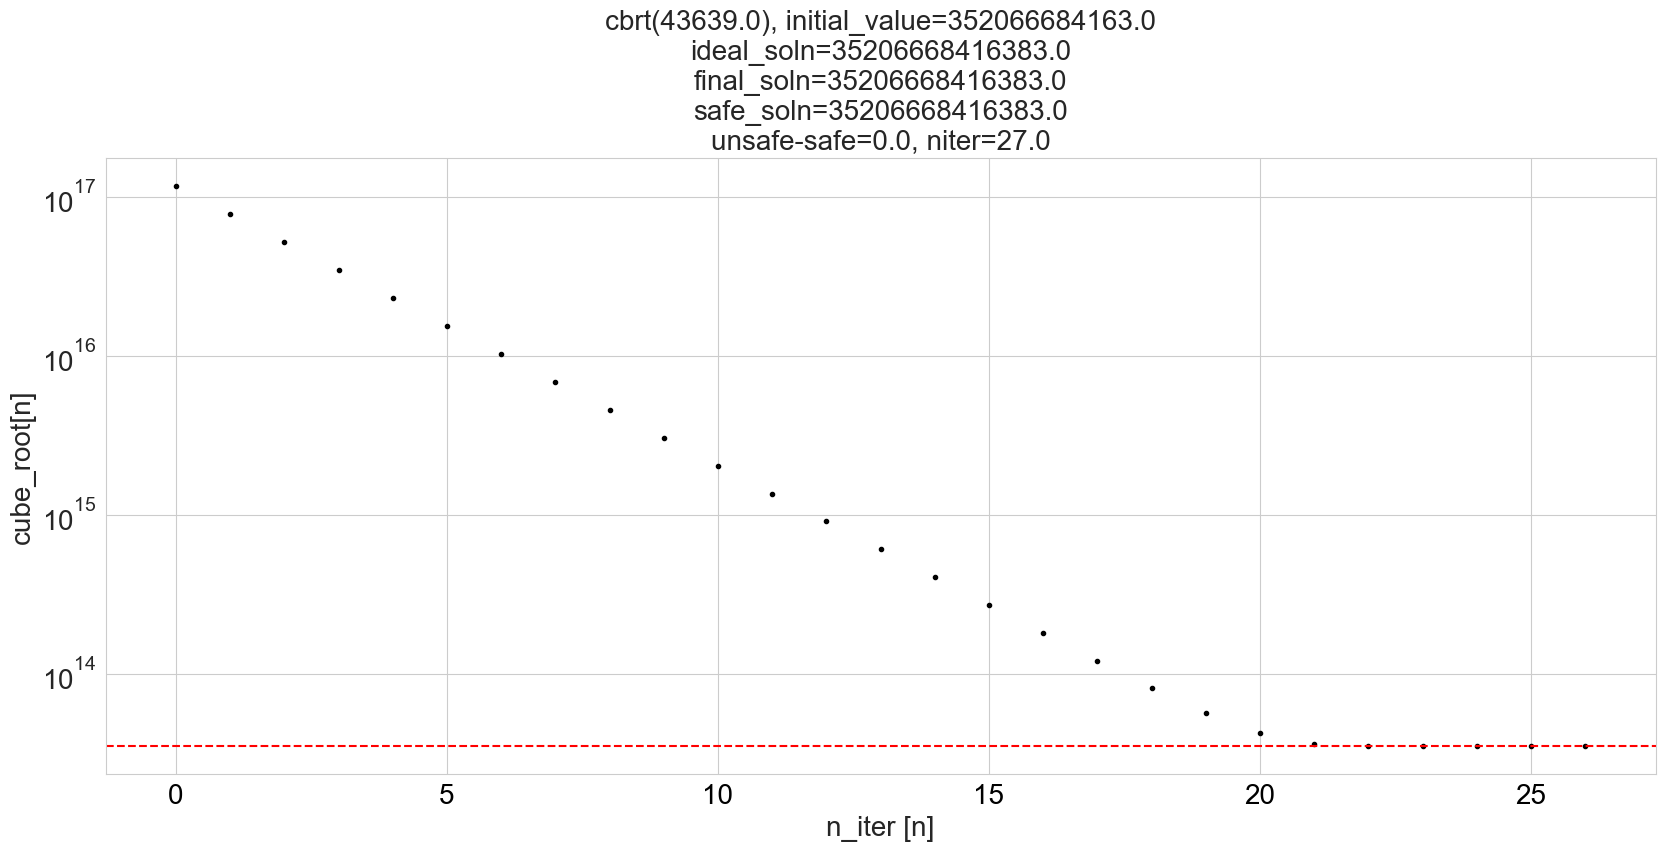

In [7]:
converged_soln = subset_data.mask(subset_data == -1).drop(
    ['input', 'initial_value', 'cbrt_ideal', 'cbrt_safe_implementation', 'cbrt_implementation'], 
    axis=1
).dropna()
plot_iterations(converged_soln.niter.idxmax())

Check if there are converged solutions that differ between safe and unsafe implementations:

In [8]:
(subset_data['cbrt_implementation'] - subset_data['cbrt_safe_implementation']).describe()

count    69343.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

In [9]:
(subset_data['cbrt_implementation'] - subset_data['cbrt_safe_implementation']).unique()

array([nan,  0.])

In [10]:
subset_data.loc[(subset_data['cbrt_implementation'] - subset_data['cbrt_safe_implementation']).idxmax()]

input                        5.807500e+04
initial_value                3.911270e+13
cbrt_ideal                   3.872544e+13
cbrt_safe_implementation     3.872544e+13
cbrt_iter_0                  3.872927e+13
                                 ...     
cbrt_iter_98                 0.000000e+00
cbrt_iter_99                 0.000000e+00
cbrt_implementation          3.872544e+13
niter                        4.000000e+00
ideal_minus_implemetation    0.000000e+00
Name: 1, Length: 107, dtype: float64

Safemath reverts for 0 whereas unsafe gets it right. Interesting ... we can ignore since we're using unsafe math.

Let's check number of iterations:

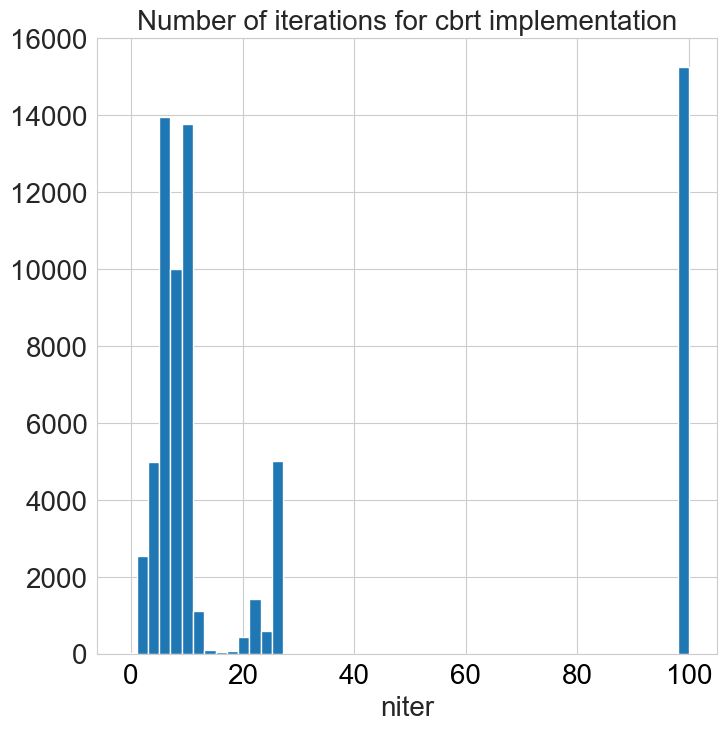

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.hist(subset_data.niter, 50)
ax.set_title("Number of iterations for cbrt implementation", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.set_xlabel("niter", fontsize=20);

For the most part, cube root estimations take about 25 iterations. The ones going to a 100 are non-convergences. 

Just looking at convergences: when do solutions actually already converge?

In [18]:
convergences = subset_data[(subset_data.niter < 100) & (subset_data.cbrt_implementation != -1) & (subset_data.cbrt_iter_0 != -1)].reset_index(drop=True)
iter_data_convergences = dd.from_pandas(
    convergences.drop(columns=[i for i in convergences.columns if not i.startswith("cbrt_iter_")]), npartitions=4
)
converged_soln = dd.from_pandas(convergences.cbrt_implementation, npartitions=1)
iter_data_convergences

,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,cbrt_iter_6,cbrt_iter_7,cbrt_iter_8,cbrt_iter_9,cbrt_iter_10,cbrt_iter_11,cbrt_iter_12,cbrt_iter_13,cbrt_iter_14,cbrt_iter_15,cbrt_iter_16,cbrt_iter_17,cbrt_iter_18,cbrt_iter_19,cbrt_iter_20,cbrt_iter_21,cbrt_iter_22,cbrt_iter_23,cbrt_iter_24,cbrt_iter_25,cbrt_iter_26,cbrt_iter_27,cbrt_iter_28,cbrt_iter_29,cbrt_iter_30,cbrt_iter_31,cbrt_iter_32,cbrt_iter_33,cbrt_iter_34,cbrt_iter_35,cbrt_iter_36,cbrt_iter_37,cbrt_iter_38,cbrt_iter_39,cbrt_iter_40,cbrt_iter_41,cbrt_iter_42,cbrt_iter_43,cbrt_iter_44,cbrt_iter_45,cbrt_iter_46,cbrt_iter_47,cbrt_iter_48,cbrt_iter_49,cbrt_iter_50,cbrt_iter_51,cbrt_iter_52,cbrt_iter_53,cbrt_iter_54,cbrt_iter_55,cbrt_iter_56,cbrt_iter_57,cbrt_iter_58,cbrt_iter_59,cbrt_iter_60,cbrt_iter_61,cbrt_iter_62,cbrt_iter_63,cbrt_iter_64,cbrt_iter_65,cbrt_iter_66,cbrt_iter_67,cbrt_iter_68,cbrt_iter_69,cbrt_iter_70,cbrt_iter_71,cbrt_iter_72,cbrt_iter_73,cbrt_iter_74,cbrt_iter_75,cbrt_iter_76,cbrt_iter_77,cbrt_iter_78,cbrt_iter_79,cbrt_iter_80,cbrt_iter_81,cbrt_iter_82,cbrt_iter_83,cbrt_iter_84,cbrt_iter_85,cbrt_iter_86,cbrt_iter_87,cbrt_iter_88,cbrt_iter_89,cbrt_iter_90,cbrt_iter_91,cbrt_iter_92,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13522,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27044,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40566,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54086,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Normalise data to percentages so we can compare:

In [35]:
diff_per_iteration = (100 * abs(iter_data_convergences.sub(convergences.cbrt_implementation, axis=0)).div(convergences.cbrt_implementation, axis=0)).compute()
diff_per_iteration[(diff_per_iteration == 100)] = -1
diff_per_iteration

,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,cbrt_iter_6,cbrt_iter_7,cbrt_iter_8,cbrt_iter_9,...,cbrt_iter_90,cbrt_iter_91,cbrt_iter_92,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99
0,0.009868,9.737087e-07,0.000000e+00,0.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.881543,7.680830e-03,5.898923e-07,0.000000,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,567.000000,3.454159e+02,1.986241e+02,102.820640,4.331692e+01,11.773317,1.196567,0.014093,1.985659e-06,0.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,14.814815,1.829370e+00,3.266793e-02,0.000011,0.000000e+00,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,567.000000,3.454159e+02,1.986241e+02,102.820640,4.331692e+01,11.773317,1.196567,0.014093,1.985658e-06,0.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54082,500.411523,3.011990e+02,1.695369e+02,84.279468,3.266876e+01,7.384158,0.496125,0.002445,5.978898e-08,0.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
54083,14.814815,1.829370e+00,3.266793e-02,0.000011,1.387706e-12,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
54084,14.814815,1.829370e+00,3.266793e-02,0.000011,1.142348e-12,0.000000,0.000000,-1.000000,-1.000000e+00,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
54085,567.000000,3.454159e+02,1.986241e+02,102.820640,4.331692e+01,11.773317,1.196567,0.014093,1.985656e-06,0.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


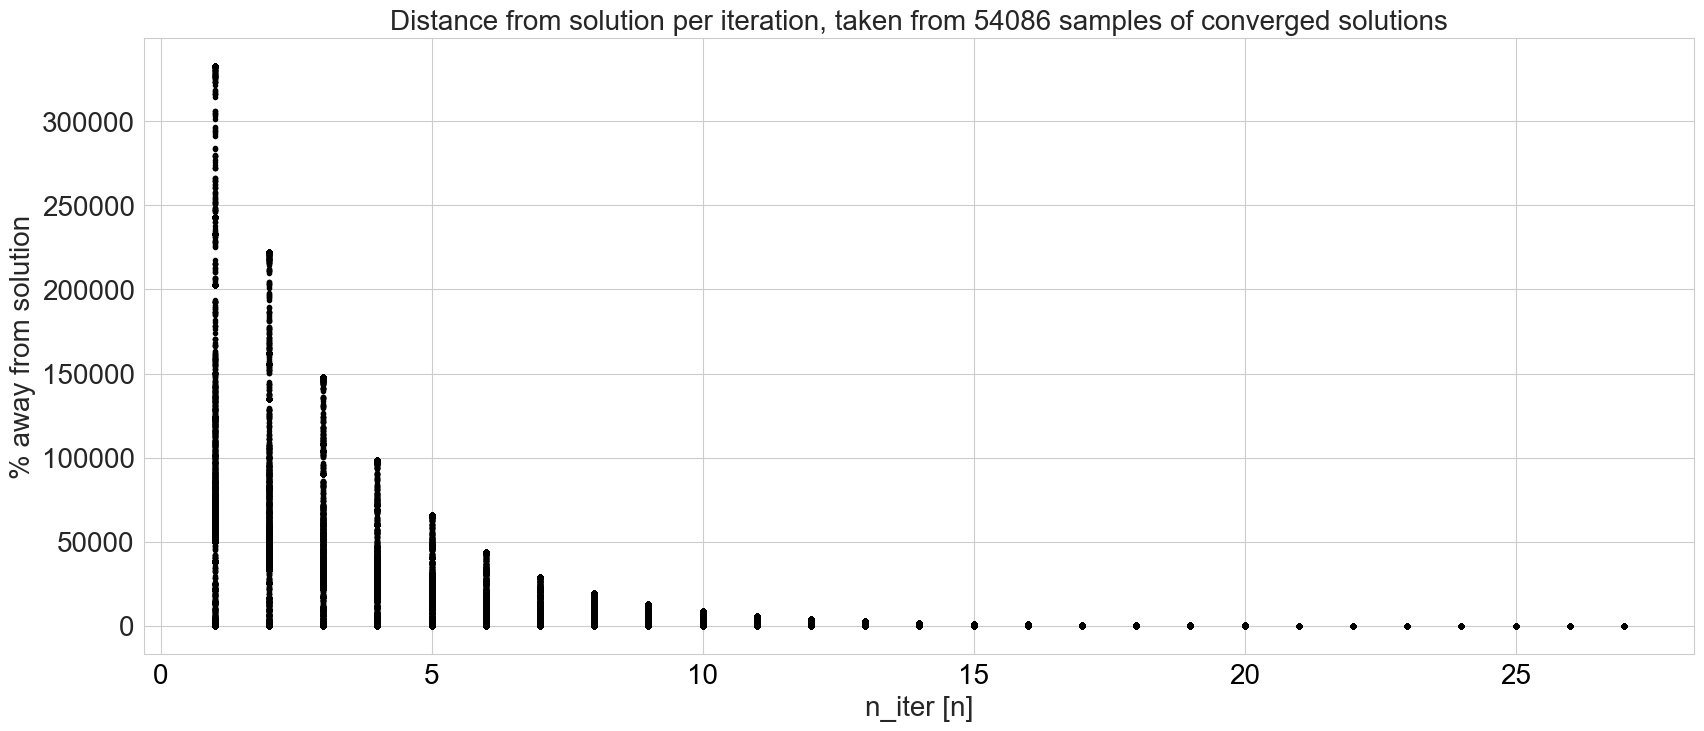

In [39]:
to_plot = diff_per_iteration
iterations = list(range(1, 101))

fig, ax = plt.subplots(1,1, figsize=(20, 8))

for i in range(to_plot.shape[0]):
    
    iter_data = to_plot.loc[i].to_list()
    iter_data = iter_data[:iter_data.index(-1)]
    
    ax.plot(
        list(range(1, len(iter_data)+1)),
        iter_data,
        '.',
        color="black",
    )


ax.set_xlabel("n_iter [n]", fontsize=20)
ax.set_ylabel("% away from solution", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.set_title("Distance from solution per iteration, taken from 54086 samples of converged solutions", fontsize=20);

According to this visualisation, regardless of how far the initial guess is from the solution, convergence occurs pretty quickly, let's say in about 15 iterations. This indicates that there may be some room for improvement in the convergence criterion.

NON-CONVERGENCES

In the contract method, the first three calculations that occur are:

1. input * 10 ** 18
2. input * 10 ** 18
3. initial_value ** 2

So, input must be <= max_uint256 / 10 ** 36 and the square of initial_value must be <= max_uint256

In [51]:
non_convergences = subset_data[(subset_data.niter == 100) & (subset_data.cbrt_implementation == -1) & (subset_data.cbrt_iter_0 == -1)].reset_index(drop=True)
non_convergences = non_convergences[["input", "initial_value", "cbrt_ideal"]]
non_convergences


,input,initial_value,cbrt_ideal
0,1.041528e+77,1.568324e+37,4.704971e+37
1,1.041528e+77,7.057457e+37,4.704971e+37
2,1.005477e+77,8.835089e+37,4.650047e+37
3,1.784016e+76,4.964626e+37,2.612961e+37
4,1.784016e+76,3.919441e+37,2.612961e+37
...,...,...,...
15251,1.157921e+77,4.487371e+38,4.874083e+37
15252,3.175045e+75,2.543366e+36,1.469772e+37
15253,3.175045e+75,1.372051e+37,1.469772e+37
15254,3.175045e+75,1.386172e+38,1.469772e+37


In [52]:
non_convergences.describe()

,input,initial_value,cbrt_ideal
count,1.525600e+04,1.525600e+04,1.525600e+04
mean,3.943616e+76,8.305914e+37,2.713132e+37
std,3.995627e+76,1.135130e+38,1.570419e+37
min,1.055469e+54,3.184123e+28,1.018158e+30
25%,1.816319e+75,1.153881e+37,1.220105e+37
50%,2.701498e+76,4.159660e+37,3.000555e+37
75%,7.394848e+76,8.792865e+37,4.197362e+37
max,1.157921e+77,4.874083e+38,4.874083e+37


In [53]:
initial_value_above_sqrt_maxuint256 = non_convergences[non_convergences.initial_value < math.sqrt(SizeLimits.MAX_UINT256)]
initial_value_above_sqrt_maxuint256

,input,initial_value,cbrt_ideal
0,1.041528e+77,1.568324e+37,4.704971e+37
1,1.041528e+77,7.057457e+37,4.704971e+37
2,1.005477e+77,8.835089e+37,4.650047e+37
3,1.784016e+76,4.964626e+37,2.612961e+37
4,1.784016e+76,3.919441e+37,2.612961e+37
...,...,...,...
15250,4.554802e+76,1.190425e+37,3.571274e+37
15252,3.175045e+75,2.543366e+36,1.469772e+37
15253,3.175045e+75,1.372051e+37,1.469772e+37
15254,3.175045e+75,1.386172e+38,1.469772e+37


In [55]:
input_above_maxuint256_by_10e36 = non_convergences[non_convergences.input > SizeLimits.MAX_UINT256 / 10**36]
input_above_maxuint256_by_10e36

,input,initial_value,cbrt_ideal
0,1.041528e+77,1.568324e+37,4.704971e+37
1,1.041528e+77,7.057457e+37,4.704971e+37
2,1.005477e+77,8.835089e+37,4.650047e+37
3,1.784016e+76,4.964626e+37,2.612961e+37
4,1.784016e+76,3.919441e+37,2.612961e+37
...,...,...,...
15251,1.157921e+77,4.487371e+38,4.874083e+37
15252,3.175045e+75,2.543366e+36,1.469772e+37
15253,3.175045e+75,1.372051e+37,1.469772e+37
15254,3.175045e+75,1.386172e+38,1.469772e+37


Now, how many iterations do we do with educated guesses?

An educated guess uses the following cor elogic:

qbrt(a) = qbrt(2**(log2(a))) = 2**(log2(a) / 3) ≈ 2**|log2(a)/3|

Generate data using [the generation script](./generate_data_educated_guess.py) and store it at [./data_educated_guess.csv](./data_educated_guess.csv)

In [94]:
data_educated_guess = pd.read_csv("./data_educated_guess.csv", low_memory=False).drop_duplicates().reset_index(drop=True)

data_educated_guess["input"] = data_educated_guess["input"].astype(float)
data_educated_guess["initial_value"] = data_educated_guess["initial_value"].astype(float)
data_educated_guess["cbrt_ideal"] = data_educated_guess["cbrt_ideal"].astype(float)
data_educated_guess["cbrt_implementation"] = data_educated_guess["cbrt_implementation"].astype(float)

for col in data.columns:
    if col.startswith("cbrt_iter"):
        data_educated_guess[col] = data_educated_guess[col].astype(float)

data_educated_guess["ideal_minus_implemetation"] = data_educated_guess.apply(
    lambda x: x["cbrt_ideal"] - x["cbrt_implementation"] if x["cbrt_implementation"] > -1 else -9999, 
    axis=1
)
data_educated_guess



,input,initial_value,cbrt_ideal,cbrt_implementation,niter,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,...,cbrt_iter_91,cbrt_iter_92,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99,ideal_minus_implemetation
0,1.0,1.048589e+12,1.000000e+12,1.000000e+12,6,1.002217e+12,1.000005e+12,1.000000e+12,1.000000e+12,1.000000e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3961.0,1.640668e+13,1.582225e+13,1.582225e+13,6,1.584282e+13,1.582228e+13,1.582225e+13,1.582225e+13,1.582225e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57105.0,4.859521e+13,3.850863e+13,3.850863e+13,7,4.045738e+13,3.860099e+13,3.850885e+13,3.850863e+13,3.850863e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60982.0,5.077084e+13,3.936110e+13,3.936110e+13,7,4.173313e+13,3.949337e+13,3.936154e+13,3.936110e+13,3.936110e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43291.0,4.040157e+13,3.511283e+13,3.511283e+13,6,3.577494e+13,3.512501e+13,3.511284e+13,3.511283e+13,3.511283e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28381,38748.0,3.752278e+13,3.383892e+13,3.383892e+13,6,3.418875e+13,3.384248e+13,3.383892e+13,3.383892e+13,3.383892e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28382,10741.0,3.190704e+13,2.206386e+13,2.206386e+13,7,2.478818e+13,2.235231e+13,2.206757e+13,2.206386e+13,2.206386e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28383,61916.0,5.128800e+13,3.956103e+13,3.956103e+13,7,4.203803e+13,3.970412e+13,3.956155e+13,3.956103e+13,3.956103e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28384,14890.0,3.967035e+13,2.460169e+13,2.460169e+13,8,2.960075e+13,2.539842e+13,2.462642e+13,2.460171e+13,2.460169e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
iter_data_convergences_educated_guess = dd.from_pandas(
    data_educated_guess.drop(
        columns=[i for i in data_educated_guess.columns if not i.startswith("cbrt_iter_")]
        ),
    npartitions=4
)
converged_soln_educated_guess = dd.from_pandas(data_educated_guess.cbrt_implementation, npartitions=1)
iter_data_convergences_educated_guess

,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,cbrt_iter_6,cbrt_iter_7,cbrt_iter_8,cbrt_iter_9,cbrt_iter_10,cbrt_iter_11,cbrt_iter_12,cbrt_iter_13,cbrt_iter_14,cbrt_iter_15,cbrt_iter_16,cbrt_iter_17,cbrt_iter_18,cbrt_iter_19,cbrt_iter_20,cbrt_iter_21,cbrt_iter_22,cbrt_iter_23,cbrt_iter_24,cbrt_iter_25,cbrt_iter_26,cbrt_iter_27,cbrt_iter_28,cbrt_iter_29,cbrt_iter_30,cbrt_iter_31,cbrt_iter_32,cbrt_iter_33,cbrt_iter_34,cbrt_iter_35,cbrt_iter_36,cbrt_iter_37,cbrt_iter_38,cbrt_iter_39,cbrt_iter_40,cbrt_iter_41,cbrt_iter_42,cbrt_iter_43,cbrt_iter_44,cbrt_iter_45,cbrt_iter_46,cbrt_iter_47,cbrt_iter_48,cbrt_iter_49,cbrt_iter_50,cbrt_iter_51,cbrt_iter_52,cbrt_iter_53,cbrt_iter_54,cbrt_iter_55,cbrt_iter_56,cbrt_iter_57,cbrt_iter_58,cbrt_iter_59,cbrt_iter_60,cbrt_iter_61,cbrt_iter_62,cbrt_iter_63,cbrt_iter_64,cbrt_iter_65,cbrt_iter_66,cbrt_iter_67,cbrt_iter_68,cbrt_iter_69,cbrt_iter_70,cbrt_iter_71,cbrt_iter_72,cbrt_iter_73,cbrt_iter_74,cbrt_iter_75,cbrt_iter_76,cbrt_iter_77,cbrt_iter_78,cbrt_iter_79,cbrt_iter_80,cbrt_iter_81,cbrt_iter_82,cbrt_iter_83,cbrt_iter_84,cbrt_iter_85,cbrt_iter_86,cbrt_iter_87,cbrt_iter_88,cbrt_iter_89,cbrt_iter_90,cbrt_iter_91,cbrt_iter_92,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7097,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14194,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21290,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28385,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [108]:
diff_per_iteration_educated_guess = (
    (
        100 * abs(
            iter_data_convergences_educated_guess.sub(
                data_educated_guess.cbrt_ideal, axis=0
                )
            ).div(data_educated_guess.cbrt_ideal, axis=0)
    ).compute()
)
diff_per_iteration_educated_guess[(abs(diff_per_iteration_educated_guess) == 100)] = -1
diff_per_iteration_educated_guess

,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,cbrt_iter_6,cbrt_iter_7,cbrt_iter_8,cbrt_iter_9,...,cbrt_iter_90,cbrt_iter_91,cbrt_iter_92,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99
0,0.221676,0.000490,2.400000e-09,0.000000e+00,0.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.130014,0.000169,2.844096e-10,0.000000e+00,0.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,5.060556,0.239843,5.734130e-04,3.287575e-09,0.000000e+00,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,6.026344,0.336037,1.124170e-03,1.263938e-08,0.000000e+00,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1.885658,0.034684,1.202403e-05,0.000000e+00,0.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28381,1.033820,0.010542,1.111265e-06,0.000000e+00,0.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
28382,12.347421,1.307316,1.679763e-02,2.820970e-06,0.000000e+00,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
28383,6.261209,0.361682,1.301858e-03,1.694850e-08,0.000000e+00,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
28384,20.320000,3.238517,1.005276e-01,1.009228e-04,1.016190e-10,0.0,0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


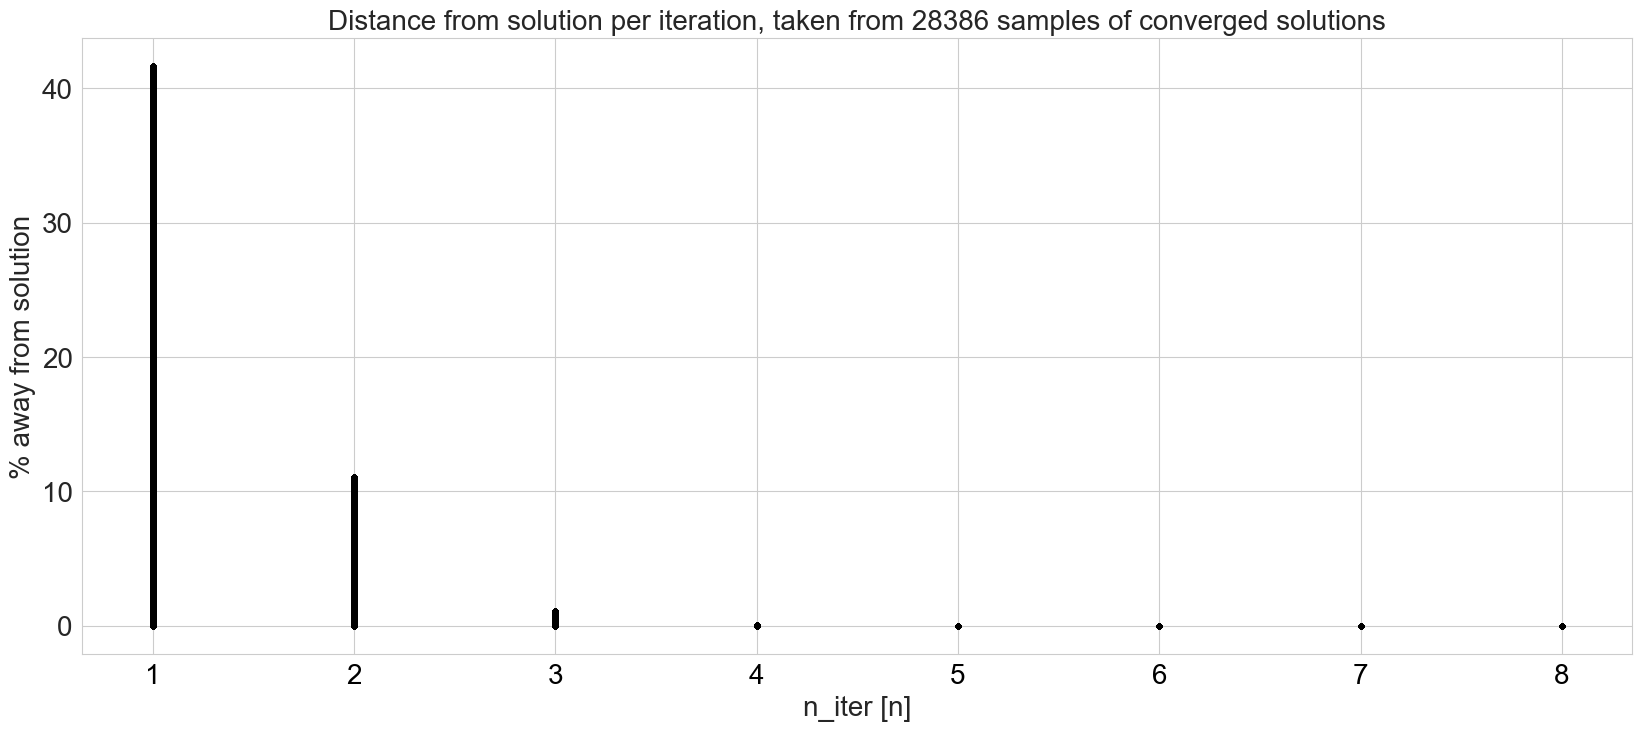

In [109]:
to_plot = diff_per_iteration_educated_guess
iterations = list(range(1, 101))

fig, ax = plt.subplots(1,1, figsize=(20, 8))

for i in range(to_plot.shape[0]):
    
    iter_data = to_plot.loc[i].to_list()
    iter_data = iter_data[:iter_data.index(-1)]
    
    ax.plot(
        list(range(1, len(iter_data)+1)),
        iter_data,
        '.',
        color="black",
    )


ax.set_xlabel("n_iter [n]", fontsize=20)
ax.set_ylabel("% away from solution", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.set_title(f"Distance from solution per iteration, taken from {to_plot.shape[0]} samples of converged solutions", fontsize=20);

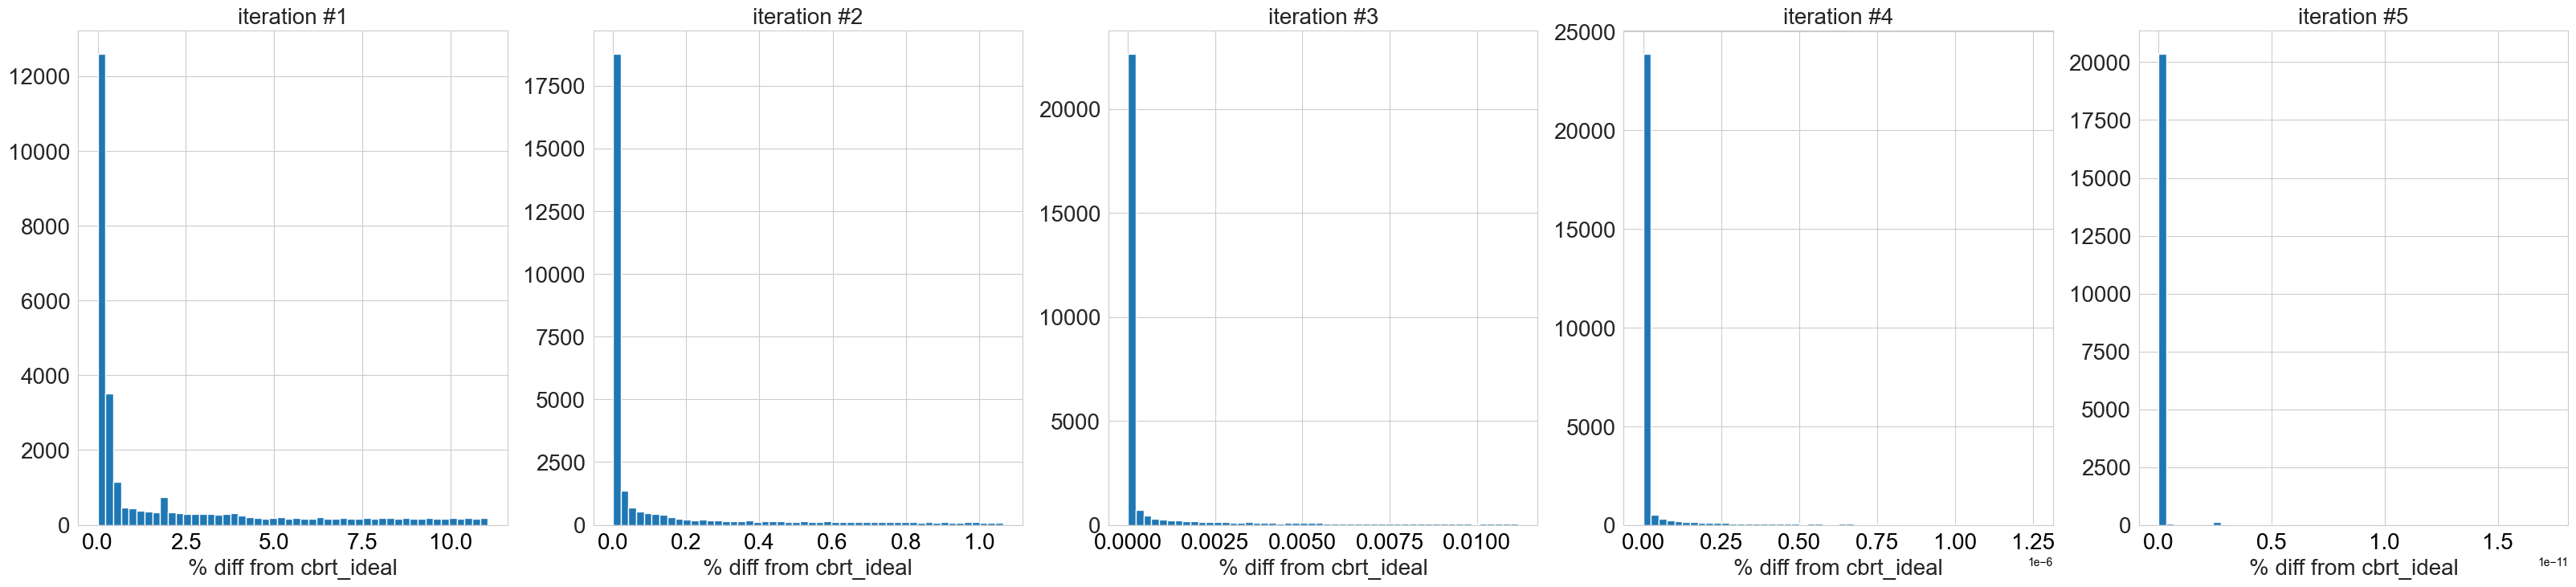

In [119]:
to_plot = diff_per_iteration_educated_guess

fig, axes = plt.subplots(1,5, figsize=(40, 8))

for i in range(5):  # for first 4 iterations
    
    iter_data = to_plot.loc[:, f"cbrt_iter_{i+1}"]
    iter_data = iter_data[iter_data != -1]
    axes[i].hist(iter_data, 50)
    axes[i].set_title(f"iteration #{i+1}", fontsize=20)


for ax in axes:
    ax.set_xlabel("% diff from cbrt_ideal", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', colors='black')

With an educated guess, we can get pretty close to the final cube root in maximally the fourth iteration.